In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cairo
import math
import imageio
import scipy.ndimage
import scipy.signal
from skimage.color import rgb2gray
import cv2 as cv
import time

import pdb

In [32]:
def quadrant(point, circle):
#     import pdb; pdb.set_trace()
    if point[0] >= circle[0] and point[1] <= circle[1]:
        return 1
    elif point[0] <= circle[0] and point[1] <= circle[1]:
        return 2
    elif point[0] <= circle[0] and point[1] >= circle[1]:
        return 3
    
    return 4    
# to-do: which arc must be decided cleverly
#        for now, it will depend on which side
#        the points are to the center of the image
#        (up/down and right/left)
def get_increase_opacity_angles(point1, point2, circle):
#     pdb.set_trace()
    zero_degrees_point = (circle[0] + circle[2], circle[1])
    
    # delta x, delta y between points
    delta1_x, delta1_y = zero_degrees_point[0] - point1[0], zero_degrees_point[1] - point1[1]
    delta2_x, delta2_y = zero_degrees_point[0] - point2[0], zero_degrees_point[1] - point2[1]
    # dist between points
    distance_points1 = math.sqrt(delta1_x**2 + delta1_y**2)
    distance_points2 = math.sqrt(delta2_x**2 + delta2_y**2)
    
    angle1 = np.arccos(1 - distance_points1**2/(2 * circle[2]**2))
    angle2 = np.arccos(1 - distance_points2**2/(2 * circle[2]**2))
    
    if quadrant(point1, circle) == 1:
        angle1 = np.pi/2 - angle1 + 3/2*np.pi
    elif quadrant(point1, circle) == 2:
        angle1 = 2*np.pi - angle1
    
    if quadrant(point2, circle) == 1:
        angle2 = np.pi/2 - angle2 + 3/2*np.pi
    elif quadrant(point2, circle) == 2:
        angle2 = 2*np.pi - angle2
    
    if ((quadrant(point1, circle) == 1 and quadrant(point2, circle) == 4) or
       (quadrant(point2, circle) == 1 and quadrant(point1, circle) == 4)):
        return max(angle1, angle2), min(angle1, angle2)
    
    
    return min(angle1, angle2), max(angle1, angle2)


def get_side(point, point1, point2):
    side = ((point2[0] - point1[0]) * (point[1] - point1[1]) - 
             (point2[1] - point1[1]) * (point[0] - point1[0]))
    
    
    if side == 0:  # on the line
        return 0
    elif side > 0: # right side
        return 1
    else:          # left side
        return -1

# might be a good idea if the points from image_points are already selected to be from the contour
# from point1 to point2 and not all points
def select_circle(image_points, point1, point2, left_circle, right_circle):
    no_left_points = 0
    no_right_points = 0
    
    for point in image_points:
        if point[0] > min(point1[0], point2[0]) and point[0] < max(point1[0], point2[0]):
            if get_side(point, point1, point2) == 1:
                no_right_points += 1
            elif get_side(point, point1, point2) == -1:
                no_left_points += 1
    
#     print("{} > {}".format(no_left_points, no_right_points))
    
    if no_left_points > no_right_points:
        return left_circle
    else:
        return right_circle

def get_circle_improved(image_points, point1, point2, scale_const):
#     pdb.set_trace()
    (point1_x, point1_y), (point2_x, point2_y) = point1, point2

    if point1 == point2:
        raise ValueError('coincident points gives infinite number of Circles')
    
    # delta x, delta y between points
    delta_x, delta_y = point2_x - point1_x, point2_y - point1_y
    # dist between points
    distance_points = math.sqrt(delta_x**2 + delta_y**2)
    
    # scaling radius selected, scale_const must be bigger than 0.5
    radius = scale_const * distance_points
    if scale_const < 0.5:
        raise ValueError('separation of points > diameter')
    
    # halfway point
    point3_x, point3_y = (point1_x + point2_x) / 2, (point1_y + point2_y) / 2
    
    # distance along the mirror line
    distance_mirror = math.sqrt(radius**2 - (distance_points / 2)**2)
    
    # One answer
    left_circle = (point3_x - distance_mirror * delta_y / distance_points,
                   point3_y + distance_mirror * delta_x / distance_points,
                   abs(radius))
    # The other answer
    right_circle = (point3_x + distance_mirror * delta_y / distance_points,
                    point3_y - distance_mirror * delta_x / distance_points,
                    abs(radius))
    
    circle = select_circle(image_points, point1, point2, left_circle, right_circle)
    
    return circle

42


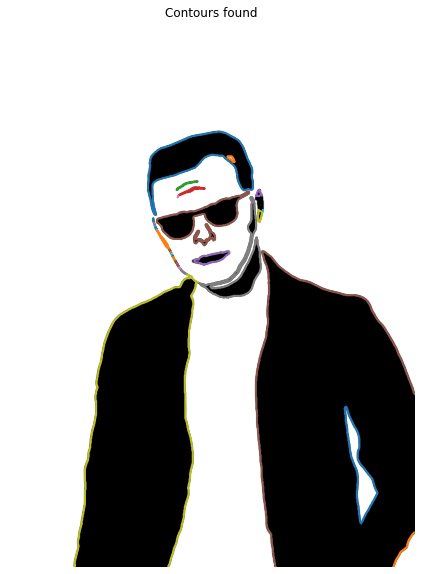

In [33]:
from skimage import measure, feature, exposure
from skimage import filters

original_image = imageio.imread("u_contour.png")
# plt.imshow(original_image)
# pdb.set_trace()
image_shape = original_image.shape
# original_image = rgb2gray(original_image[:,:,:3]).astype(np.uint8)
original_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
# original_image = cv.equalizeHist(original_image)
original_image = cv.fastNlMeansDenoising(original_image, None, 30, 3, 21)
# original_image = exposure.adjust_gamma(original_image, 2, 2)
# pdb.set_trace()
# plt.imshow(original_image, cmap='gray')

# thresh_mean = filters.threshold_mean(original_image)
# original_image = original_image > thresh_mean
# original_image = filters.threshold_local(original_image, 15)

# canny_image = feature.canny(original_image, sigma=0.4)
# canny_image = canny_image.astype(np.uint8) * 255
# canny_image = np.invert(canny_image)
# plt.imshow(canny_image)
# pdb.set_trace()
contours = measure.find_contours(original_image, 
                                 0, 
                                 fully_connected='high',
                                 positive_orientation='low')

print(len(contours))

plt.figure(figsize=(10, 10))
plt.imshow(original_image, cmap='gray')
for _, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.title('Contours found')
plt.axis('off')

plt.show()

In [34]:
# print(len(contours[0]))
# print(contours[0])

# plt.figure(figsize=(15, 15))
# ax = plt.gca()
# ax.set_aspect('equal')
# ax.set_ylim(0, 1080)
# ax.set_ylim(ax.get_ylim()[::-1])
# ax.xaxis.tick_top()
# ax.yaxis.tick_left()
# # plt.imshow(original_image, cmap='gray')

# plt.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)

In [35]:
def plot_contour(contour):
    plt.figure(figsize=(15, 15))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_ylim(0, 1080)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.xaxis.tick_top()
    ax.yaxis.tick_left()   
    # plt.imshow(original_image, cmap='gray')

    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [36]:
# findcontours gives [y-coordonate, x-coordinate], we'll swap them
for index2, _ in enumerate(contours):
    for index in range(len(contours[index2])):
        contours[index2][index][0], contours[index2][index][1] = contours[index2][index][1], contours[index2][index][0]

contour = contours[4]
contour = contour[1::5]
        
# points_size = [5 for _ in range(0,len(contour))]

# plt.figure(figsize=(15,15))
# plt.scatter(contour[:, 1], contour[:, 0], s=points_size)


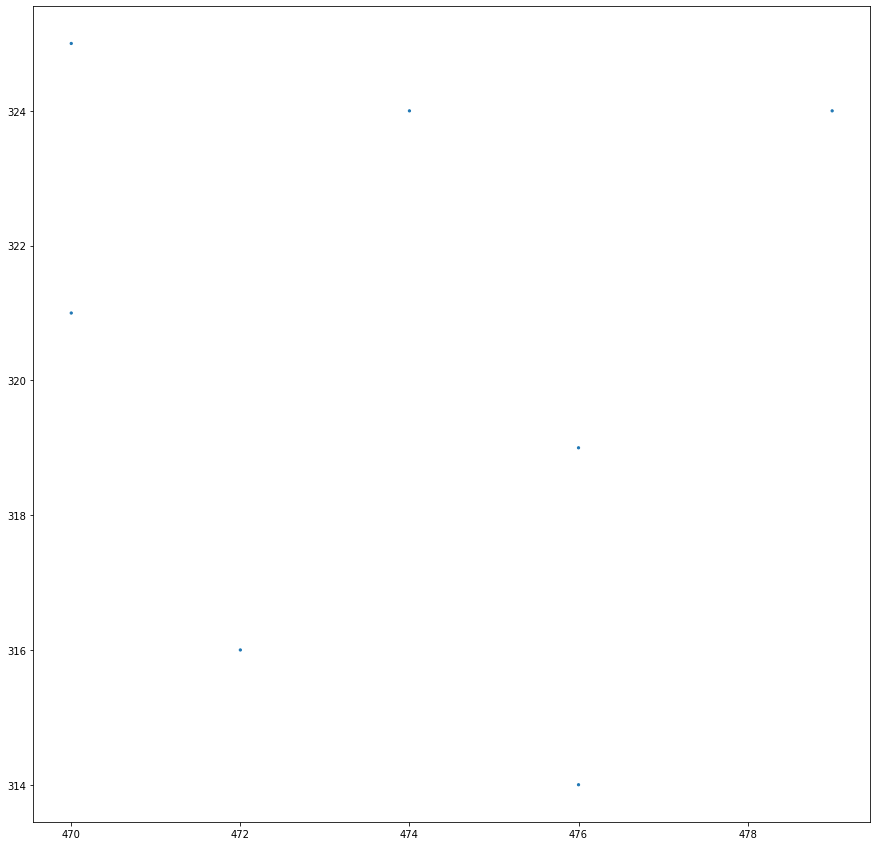

In [37]:
points = contour

points_size = [5 for _ in range(0,len(points))]

plt.figure(figsize=(15,15))
plt.scatter(points[:, 0], points[:, 1], s=points_size)

In [38]:
from numpy.linalg import pinv, inv

sigma_3 = np.pi / 3

def distance_between(point1, point2):
    x1, y1 = point1[0], point1[1]
    x2, y2 = point2[0], point2[1]
    
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

# def max_deviation(circle, points):
#     radius = circle[2]
#     center = (circle[0], circle[1])
    
#     deviation = 0
#     for point in points:
#         distance = distance_between(center, point)
#         if distance > deviation:
#             deviation = distance
    
#     return deviation

# def end_abruptness_c(last_point, current_point, deviation):
#     delta_y = np.absolute(current_point[1] - last_point[1])
#     delta_x = current_point[0] - last_point[0]
# #     pdb.set_trace()
#     return max(0, min(1, (max(0, (delta_y - deviation))/(deviation + delta_x * np.tan(sigma_3)))))

def deriv1(x_n, x):
    return (x_n[0] - x[0])/np.sqrt((x_n[0] - x[0])**2 + (x_n[1] - x[1])**2)

def deriv2(x_n, x):
    return (x_n[1] - x[1])/np.sqrt((x_n[0] - x[0])**2 + (x_n[1] - x[1])**2)

def jacobian(x_n, points):
    J = np.ones((len(points), 3))
    J = -J
    
    J[:,0] = [deriv1(x_n, x) for x in points]
    J[:,1] = [deriv2(x_n, x) for x in points]
    J[:,2] = [-1 for _ in range(0, len(points))]
    
    return J

def distance(x_n, point):
    x1, y1 = x_n[0], x_n[1]
    x2, y2 = point[0], point[1]
    
    radius = x_n[2]
    
    return np.sqrt((x1-x2)**2 + (y1-y2)**2) - radius

def distances(x_n, points):
    r = [distance(x_n, x) for x in points]
    
    return r

def least_squares_circle(circle, points):
    x_n = circle
    for i in range(0, 20):
        J = jacobian(x_n, points)
        r = distances(x_n, points)
#         print(r)
        x_n_new = x_n - np.matmul(pinv(np.nan_to_num(np.matmul(np.transpose(J), J), 0)), np.matmul(np.transpose(J), r))
        x_n = x_n_new
    
    return x_n

In [47]:
# x_n = np.array([min(points[0][0], points[-1][0]) + np.abs(points[0][0]-points[-1][0])/2, min(points[0][1], points[-1][1]) + np.abs(points[0][1]-points[-1][1])/2, distance_between(points[0],points[-1])/2])
# x_n = least_squares_circle(x_n, points)

def get_circle_from_points(points):
    return [min(points[0][0], points[-1][0]) + np.abs(points[0][0]-points[-1][0])/2,
            min(points[0][1], points[-1][1]) + np.abs(points[0][1]-points[-1][1])/2, 
            distance_between(points[0],points[-1])/2]

def get_average_deviation(circle, points):
    center = [circle[0], circle[1]]
    radius = circle[2]
    
    deviations = [distance_between(center, point) - radius for point in points]

    return sum(deviations) / len(deviations)

def get_fit_quality(circle, points):
    average_deviation = get_average_deviation(circle, points)
    
    if average_deviation == 0:
        return 2**31-1
    else:
        return len(points) / average_deviation

def get_circles(points):
    current_circle = []
    current_point = 0
    cnt = 0
    circles = []
    segments = []
    end_points = []
    no_points_selected = 20
    while current_point < len(points):
        if len(current_circle) == 0:
            if current_point + no_points_selected > len(points):
    #             print("pula")
    #             break
                current_points = points[len(points)-20:len(points)]
                current_point = len(points)

                current_circle = get_circle_from_points([current_points[0], current_points[-1]])
                current_circle = least_squares_circle(current_circle, current_points)

                segments.append(current_points)
                circles.append(current_circle)
            else:
                current_points = points[current_point:current_point+20]
                current_point += no_points_selected
    #         pdb.set_trace()
            current_circle = get_circle_from_points([current_points[0], current_points[-1]])
            current_circle = least_squares_circle(current_circle, current_points)

            current_fit_quality = get_fit_quality(current_circle, current_points)
            end_points.append(current_points[-1])
        else:
            current_points = np.concatenate((current_points, [points[current_point]]))
            current_update_fit_quality = get_fit_quality(current_circle, current_points)
            if current_update_fit_quality <= 0.8 * current_fit_quality:
    #             update points 
                if len(current_points) % no_points_selected == 0:
                    current_circle = least_squares_circle(current_circle, current_points)
                current_fit_quality = get_fit_quality(current_circle, current_points)

                current_point += 1
            else:
                current_circle = least_squares_circle(current_circle, current_points[:len(current_points)-1])
                current_fit_quality = get_fit_quality(current_circle, current_points[:len(current_points)-1])

                segments.append(current_points)
                circles.append(current_circle)

                current_circle = []
    #         if cnt > 1000:
    #             break
    
    segments_start_end_points = [[segment[0], segment[-1]] for segment in segments]

    end_points = [end_points[1] for end_points in segments_start_end_points]
    end_points = [x.tolist() for x in end_points]

    end_points = np.array(end_points)
    return end_points, circles

In [48]:
# print(len(circles))
# plt.figure(figsize=(20, 20))
# plt.scatter(points[:, 0], points[:, 1], s=points_size)

# # for circle in circles:
# #     ax.add_artist(plt.Circle((circle[0], circle[1]), circle[2], color='b', fill=False))

# # circle_plot = plt.Circle((x_n[0], x_n[1]), x_n[2], color='b', fill=False)
# # circle_plot = plt.Circle((first_circle[0], first_circle[1]), first_circle[2], color='b', fill=False)

# ax = plt.gca()

# ax.set_xlim(0, image_shape[0])
# ax.set_ylim(0, image_shape[1])

# for index, circle in enumerate(circles):
#     ax.add_artist(plt.Circle((circle[0], circle[1]), circle[2], fill=False))
# # ax.add_artist(circle_plot)

# plt.show()

In [49]:
# segments_start_end_points = [[segment[0], segment[-1]] for segment in segments]

# start_points = [end_points[0] for end_points in segments_start_end_points]
# end_points = [end_points[1] for end_points in segments_start_end_points]
# start_points = [x.tolist() for x in start_points]
# end_points = [x.tolist() for x in end_points]

# start_points = np.array(start_points)
# end_points = np.array(end_points)

# end_points_size = [20 for _ in range(0,len(end_points))]
# print(points.shape)

In [50]:
# plt.figure(figsize=(20, 20))
# plt.scatter(start_points[:, 0], start_points[:, 1], s=end_points_size)
# plt.scatter(end_points[:, 0], end_points[:, 1], s=end_points_size)
# plt.scatter(points[:, 0], points[:, 1], s=points_size)

# # for circle in circles:
# #     ax.add_artist(plt.Circle((circle[0], circle[1]), circle[2], color='b', fill=False))

# # circle_plot = plt.Circle((x_n[0], x_n[1]), x_n[2], color='b', fill=False)
# # circle_plot = plt.Circle((first_circle[0], first_circle[1]), first_circle[2], color='b', fill=False)

# ax = plt.gca()

# # ax.set_xlim(0, image_shape[1])
# # ax.set_ylim(0, image_shape[0])

# for index, circle in enumerate(circles):
#     ax.add_artist(plt.Circle((circle[0], circle[1]), circle[2], fill=False))
# # ax.add_artist(circle_plot)

# plt.show()

In [51]:
def plot_circles_and_points(circle0, circle1, circle2, point1, point2):
    plt.figure(figsize=(5, 5))
    
    new_points = np.zeros((2,2))
    new_points[0] = point1
    new_points[1] = point2
    
    plt.scatter(new_points[:, 0], new_points[:, 1], s=[20, 20])
    ax = plt.gca()

    ax.set_xlim(0, 800)
    ax.set_ylim(0, 800)

    ax.add_artist(plt.Circle((circle0[0], circle0[1]), circle0[2], fill=False, color='green'))
    ax.add_artist(plt.Circle((circle1[0], circle1[1]), circle1[2], fill=False, color='red'))
    ax.add_artist(plt.Circle((circle2[0], circle2[1]), circle2[2], fill=False, color='green'))
    # ax.add_artist(circle_plot)

    plt.show()
    
def plot_circle_and_points(circle, point1, point2):
    plt.figure(figsize=(10, 10))
    
    new_points = np.zeros((2,2))
    new_points[0] = point1
    new_points[1] = point2
    
    plt.scatter(new_points[:, 0], new_points[:, 1], s=[20, 20])
    ax = plt.gca()

    ax.set_xlim(0, image_shape[0])
    ax.set_ylim(0, image_shape[1])

    
    ax.add_artist(plt.Circle((circle[0], circle[1]), circle[2], fill=False))
    # ax.add_artist(circle_plot)

    plt.show()

In [52]:
def point_not_valid(point):
    if np.isnan(point[0]) or np.isnan(point[1]):
        return True
    else:
        return False
    
def get_intersection(circle1, circle2):
    center1_x = circle1[0]
    center1_y = circle1[1]
    radius1 = circle1[2]
    
    center2_x = circle2[0]
    center2_y = circle2[1]
    radius2 = circle2[2]
    
#     print(f"circles: ({center1_x},{center1_y},{radius1} and {center2_x},{center2_y},{radius2})")
    
    if distance_between((center1_x, center1_y), (center2_x, center2_y)) > radius1 + radius2:
        return None
    
    d = np.sqrt((center1_x - center2_x)**2 + (center1_y - center2_y)**2)
    l = (radius1**2 - radius2**2 + d**2) / (2 * d)
    h = np.sqrt(radius1**2 - l**2)
    
    x1 = (l/d)*(center2_x - center1_x) + (h/d)*(center2_y - center1_y) + center1_x
    x2 = (l/d)*(center2_x - center1_x) - (h/d)*(center2_y - center1_y) + center1_x
    
    y1 = (l/d)*(center2_y - center1_y) - (h/d)*(center2_x - center1_x) + center1_y
    y2 = (l/d)*(center2_y - center1_y) + (h/d)*(center2_x - center1_x) + center1_y
    
#     print([(x1, y1), (x2, y2)])
    
    return [(x1, y1), (x2, y2)]
    
def get_wanted_point(intersection, supposed_intersection_point):
#     pdb.set_trace()
    if intersection == None:
        return None
    if distance_between(intersection[0], supposed_intersection_point) < distance_between(intersection[1], supposed_intersection_point):
        return intersection[0]
    else:
        return intersection[1]

def get_line_circle_intersection(point1, point2, circle):
#     print(f"points: {point1}; {point2}")
#     print(f"circle: {circle}")
    point1_x, point1_y = point1
    point2_x, point2_y = point2
    
    radius = circle[2]
    
    point1_x -= circle[0]
    point2_x -= circle[0]
    point1_y -= circle[1]
    point2_y -= circle[1]
    
    d_x = point2_x - point1_x
    d_y = point2_y - point1_y

    d_r = np.sqrt(d_x**2 + d_y**2)
    D = point1_x * point2_y - point2_x * point1_y
    
    x1 = (D*d_y+np.sign(d_y)*d_x*np.sqrt(radius**2*d_r**2-D**2))/(d_r**2)
    y1 = (-D*d_x+np.absolute(d_y)*np.sqrt(radius**2*d_r**2-D**2))/(d_r**2)
    
    x2 = (D*d_y-np.sign(d_y)*d_x*np.sqrt(radius**2*d_r**2-D**2))/(d_r**2)
    y2 = (-D*d_x-np.absolute(d_y)*np.sqrt(radius**2*d_r**2-D**2))/(d_r**2)
    
    return (x1+circle[0], y1+circle[1]), (x2+circle[0], y2+circle[1])
    
def get_closest_points(circle1, circle2):
    center1_x = circle1[0]
    center1_y = circle1[1]
    radius1 = circle1[2]
    
    center2_x = circle2[0]
    center2_y = circle2[1]
    radius2 = circle2[2]
    
    if distance_between((center1_x, center1_y), (center2_x, center2_y)) <= radius1 + radius2:
#         print("plm")
        point1_1, point1_2 = get_line_circle_intersection(
            (center1_x, center1_y), 
            (center2_x, center2_y), 
            circle1)
        point2_1, point2_2 = get_line_circle_intersection(
            (center1_x, center1_y), 
            (center2_x, center2_y), 
            circle2)
        
#         print(f"first points: {point1_1}; {point1_2}")
#         print(f"first points: {point2_1}; {point2_2}")
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        
        distances = np.zeros(4)
        distances[0] = distance_between(point1_1, point2_1)
        distances[1] = distance_between(point1_1, point2_2)
        distances[2] = distance_between(point1_2, point2_1)
        distances[3] = distance_between(point1_2, point2_2)
        
        wanted_points = np.argmin(distances)
        
        if wanted_points == 0:
            return [point1_1, point2_1]
        elif wanted_points == 1:
            return [point1_1, point2_2]
        elif wanted_points == 2:
            return [point1_1, point2_1]
        else:
            return [point1_2, point2_2]
        
#         if radius1 < radius2:
#             if distance_between(point1_1, (center2_x, center2_y)) < distance_between(point1_2, (center2_x, center2_y)):
#                 circle1_point_x = point1_1[0]
#                 circle1_point_y = point1_1[1]
#             else:
#                 circle1_point_x = point1_2[0]
#                 circle1_point_y = point1_2[1]
            
#             if distance_between((circle1_point_x, circle1_point_y), point2_1) < distance_between((circle1_point_x, circle1_point_y), point2_2):
#                 circle2_point_x = point2_1[0]
#                 circle2_point_y = point2_1[1]
#             else:
#                 circle2_point_x = point2_2[0]
#                 circle2_point_y = point2_2[1]
#         else:
#             if distance_between(point2_1, (center1_x, center1_y)) < distance_between(point2_2, (center1_x, center1_y)):
#                 circle2_point_x = point2_1[0]
#                 circle2_point_y = point2_1[1]
#             else:
#                 circle2_point_x = point2_2[0]
#                 circle2_point_y = point2_2[1]
            
#             if distance_between((circle2_point_x, circle2_point_y), point1_1) < distance_between((circle2_point_x, circle2_point_y), point1_2):
#                 circle1_point_x = point1_1[0]
#                 circle1_point_y = point1_1[1]
#             else:
#                 circle1_point_x = point1_2[0]
#                 circle1_point_y = point1_2[1]
                            
#             plot_circles_and_points(circle1, circle2, circle1, (circle1_point_x, circle1_point_y), (circle2_point_x, circle2_point_y))          
    else:
        v1_x = center2_x - center1_x
        v1_y = center2_y - center1_y

        v2_x = center1_x - center2_x
        v2_y = center1_y - center2_y

        circle1_point_x = center1_x +  (v1_x/np.sqrt(v1_x**2 + v1_y**2)) * radius1
        circle1_point_y = center1_y +  (v1_y/np.sqrt(v1_x**2 + v1_y**2)) * radius1

        circle2_point_x = center2_x +  (v2_x/np.sqrt(v2_x**2 + v2_y**2)) * radius2
        circle2_point_y = center2_y +  (v2_y/np.sqrt(v2_x**2 + v2_y**2)) * radius2
    
    return [circle1_point_x, circle1_point_y], [circle2_point_x, circle2_point_y]
    
def get_circle_intersections(circles, points, end_points):
#     pdb.set_trace()
#     print(len(circles))
    circle_intersection = [[(np.nan, np.nan), (np.nan, np.nan)] for i in range(0, len(circles))]
    
    for index, _ in enumerate(circles[:len(circles)-1]):
#         print(index)
#         pdb.set_trace()
        intersection = get_intersection(circles[index], circles[index+1])
        wanted_point = get_wanted_point(intersection, end_points[index])

        if wanted_point != None and point_not_valid(wanted_point) == False:
            circle_intersection[index][1] = wanted_point
            circle_intersection[index+1][0] = wanted_point
        else:
            wanted_point1, wanted_point2 = get_closest_points(circles[index], circles[index+1])
            circle_intersection[index][1] = wanted_point1
            circle_intersection[index+1][0] = wanted_point2
            

    intersection = get_intersection(circles[0], circles[-1])
    wanted_point = get_wanted_point(intersection, end_points[-1])

    if wanted_point != None and point_not_valid(wanted_point) == False:
        circle_intersection[0][0] = wanted_point
        circle_intersection[-1][1] = wanted_point
    else:
        wanted_point1, wanted_point2 = get_closest_points(circles[0], circles[-1])
        circle_intersection[index][1] = wanted_point1
        circle_intersection[index+1][0] = wanted_point2
#     pdb.set_trace()
#     print(circle_intersection)
    return circle_intersection

In [53]:
def get_new_background(background, layer):
#     pdb.set_trace()
    background[background==255] = layer[background==255]
    return background

def create_circle_layer(image_points, circle, fp, sp, surface_shape):
    width, height, channels = surface_shape
    
    background = np.zeros((width, height, channels), dtype=np.uint8)
    main_surface = cairo.ImageSurface.create_for_data(
        background, cairo.FORMAT_ARGB32, width, height)

    cr = cairo.Context(main_surface)

    # draw background
    cr.set_source_rgba(1.0, 1.0, 1.0, 1)
    cr.paint()

    # draw the two points
    point1 = fp
    point2 = sp
    
    # draw the transparent circle
    cr.set_source_rgba(1, 0.2, 0.2, 0.1)
    cr.arc(circle[0], circle[1], circle[2], 0, 2*math.pi)
    cr.set_line_width(3)
    cr.stroke()

    # increase opacity
    angle_start, angle_stop = get_increase_opacity_angles(point2, point1, circle)
    
    # draw the circle
    cr.set_source_rgba(1, 0.2, 0.2, 1)
    cr.arc(circle[0], circle[1], circle[2], angle_start, angle_stop)
    cr.set_line_width(3)
    cr.stroke()
    
    return background

def create_image(contours, image_shape):
        
    width, height, channels = image_shape

    background = np.zeros(image_shape, dtype=np.uint8)
    main_surface = cairo.ImageSurface.create_for_data(
        background, cairo.FORMAT_ARGB32, width, height)

    cr = cairo.Context(main_surface)

    # draw background
    cr.set_source_rgba(1.0, 1.0, 1.0, 1)
    cr.paint()
    
#     plt.figure(figsize=(20, 20))
#     ax = plt.gca()

#     ax.set_xlim(0, 800)
#     ax.set_ylim(0, 800)    
    # ax.add_artist(circle_plot)

#     plt.show()
    
    cnt = 0
    for points in contours:
        if len(points) > 40:
            cnt += 1
    #         pdb.set_trace()
            end_points, circles = get_circles(points)
            if len(circles) > 3:
#                 pdb.set_trace()
                print(f"Currently at contour {cnt} out of {len(contours)}")
                circles_intersections = get_circle_intersections(circles, points, end_points)
                for index, circle in enumerate(circles):
            #         if index != 26:
                    first_point = circles_intersections[index][0]
                    second_point = circles_intersections[index][1]

            #         new_points = np.zeros((2,2))
            #         new_points[0] = first_point
            #         new_points[1] = second_point

            #         plt.scatter(new_points[:, 0], new_points[:, 1], s=[20, 20])


            #         ax.add_artist(plt.Circle((circle[0], circle[1]), circle[2], fill=False, color='red'))

            #         if (index >= 25 and index <= 26):
            #             print(index)
            #             if index+1 == len(circles):
            #                 plot_circles_and_points(circles[index-1], circles[index], circles[0], first_point, second_point)
            #             else:
            #                 plot_circles_and_points(circles[index-1], circles[index], circles[index+1], first_point, second_point)
            #         else:
            #         pdb.set_trace()
        #             circle_layer = create_circle_layer(points, circle, first_point, second_point, image_shape)
        # #             circle_layer[circle_layer==255] = 0
        # #             pdb.set_trace()
        #             background = get_new_background(background, circle_layer)
                    cr.set_source_rgba(1, 0.2, 0.2, 0.1)
                    cr.arc(circle[0], circle[1], circle[2], 0, 2*math.pi)
                    cr.set_line_width(3)
                    cr.stroke()

                    # increase opacity
                    angle_start, angle_stop = get_increase_opacity_angles(second_point, first_point, circle)

                    # draw the circle
                    cr.set_source_rgba(1, 0.2, 0.2, 1)
                    cr.arc(circle[0], circle[1], circle[2], angle_start, angle_stop)
                    cr.set_line_width(3)
                    cr.stroke()
            #             pdb.set_trace()


            #     plt.show()
    return background, main_surface
    

In [54]:
image, surface = create_image(contours, (1200, 1200, 4))

surface.write_to_png("cool_2.png")

<ipython-input-38-b88108d0f7b9>:30: RuntimeWarning: invalid value encountered in double_scalars
  return (x_n[0] - x[0])/np.sqrt((x_n[0] - x[0])**2 + (x_n[1] - x[1])**2)
<ipython-input-38-b88108d0f7b9>:33: RuntimeWarning: invalid value encountered in double_scalars
  return (x_n[1] - x[1])/np.sqrt((x_n[0] - x[0])**2 + (x_n[1] - x[1])**2)
<ipython-input-52-ec664c260754>:23: RuntimeWarning: invalid value encountered in sqrt
  h = np.sqrt(radius1**2 - l**2)


Currently at contour 1 out of 42
Currently at contour 3 out of 42
Currently at contour 4 out of 42
Currently at contour 5 out of 42
Currently at contour 7 out of 42
Currently at contour 8 out of 42


<ipython-input-32-b973e1918e9c>:26: RuntimeWarning: invalid value encountered in arccos
  angle1 = np.arccos(1 - distance_points1**2/(2 * circle[2]**2))


Currently at contour 9 out of 42
Currently at contour 10 out of 42
Currently at contour 11 out of 42
Currently at contour 12 out of 42
Currently at contour 13 out of 42


In [ ]:
plt.imshow(image.astype(np.uint8))

In [ ]:
print(len(contours))